In [ ]:
!unzip archive.zip

Archive:  archive.zip
replace test_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve

from lightgbm import LGBMClassifier
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

from scipy.optimize import minimize_scalar, minimize

from tqdm import tqdm_notebook
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train_data.csv')
train_data.head()

,Tier,FICO,Term,Amount,Previous_Rate,Competition_rate,Rate,Cost_Funds,Partner Bin,Car_Type_N,Car_Type_R,Car_Type_U,Accept
0,2,725,72,30500.0,5,6.09,4.99,1.1200,2,0,1,0,0
1,1,739,60,25995.0,-10,4.79,4.79,1.9590,2,0,0,1,0
2,1,781,60,39000.0,-10,4.25,4.25,1.1200,2,1,0,0,0
3,2,718,72,30000.0,-10,5.39,5.44,1.3363,1,1,0,0,1
4,2,703,72,38000.0,-10,5.75,6.29,1.1338,1,0,0,1,0


In [3]:
train_data.describe()

,Tier,FICO,Term,Amount,Previous_Rate,Competition_rate,Rate,Cost_Funds,Partner Bin,Car_Type_N,Car_Type_R,Car_Type_U,Accept
count,145659.000000,145659.000000,145659.000000,145659.000000,145659.000000,145659.000000,145659.000000,145659.000000,145659.000000,145659.000000,145659.000000,145659.000000,145659.000000
mean,1.928429,726.695556,56.822441,25996.819760,-6.001435,4.807957,5.623998,1.329209,2.029473,0.571815,0.226865,0.201320,0.220041
std,1.050519,44.727756,11.201037,11125.968255,7.499216,0.586018,1.545418,0.278368,0.911097,0.494817,0.418806,0.400988,0.414276
min,1.000000,594.000000,36.000000,4526.620000,-10.000000,2.990000,2.450000,1.020000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,692.000000,48.000000,17753.450000,-10.000000,4.390000,4.490000,1.110000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,726.000000,60.000000,25000.000000,-10.000000,4.790000,5.090000,1.262500,2.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,762.000000,60.000000,33000.000000,-10.000000,5.190000,6.390000,1.419400,3.000000,1.000000,0.000000,0.000000,0.000000
max,4.000000,852.000000,72.000000,100000.000000,24.000000,6.450000,15.530000,2.127000,3.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
test_data = pd.read_csv('test_data.csv')
test_data.head()

,Tier,FICO,Term,Amount,Previous_Rate,Competition_rate,Rate,Cost_Funds,Partner Bin,Car_Type_N,Car_Type_R,Car_Type_U,Accept
0,4,656,60,19600.0,-10,5.49,7.89,1.80,1,1,0,0,0
1,2,708,60,25921.0,8,5.49,7.02,1.99,2,0,1,0,0
2,4,666,60,18542.0,-10,5.75,7.89,1.82,3,0,0,1,0
3,1,749,48,18000.0,-10,4.89,4.14,1.34,1,1,0,0,1
4,2,709,60,25000.0,-10,4.25,4.69,1.11,1,1,0,0,0


In [5]:
test_data.describe()

,Tier,FICO,Term,Amount,Previous_Rate,Competition_rate,Rate,Cost_Funds,Partner Bin,Car_Type_N,Car_Type_R,Car_Type_U,Accept
count,62426.000000,62426.000000,62426.000000,62426.000000,62426.000000,62426.000000,62426.000000,62426.000000,62426.000000,62426.000000,62426.000000,62426.000000,62426.000000
mean,1.924679,726.815061,56.777689,26039.140706,-5.993320,4.805026,5.620835,1.327908,2.030132,0.572982,0.226909,0.200109,0.220037
std,1.052197,44.913758,11.211280,11068.667027,7.513858,0.586453,1.550624,0.277319,0.910987,0.494649,0.418836,0.400085,0.414274
min,1.000000,587.000000,36.000000,5.000000,-10.000000,2.990000,2.590000,1.020000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,692.000000,48.000000,17843.192500,-10.000000,4.390000,4.490000,1.110000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,726.000000,60.000000,25000.000000,-10.000000,4.790000,5.090000,1.252500,2.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,763.000000,60.000000,33000.000000,-10.000000,5.190000,6.340000,1.417500,3.000000,1.000000,0.000000,0.000000,0.000000
max,4.000000,854.000000,72.000000,100000.000000,24.000000,6.450000,13.900000,2.127000,3.000000,1.000000,1.000000,1.000000,1.000000


## Acceptance modeling:

In [6]:
num_cols = [
    'FICO',
    'Term',
    'Amount',
    'Previous_Rate',
    'Competition_rate',
#     'Rate',
    'Cost_Funds'
]

cat_cols = [
    'Tier',
    'Partner Bin'
]

other = [
    'Rate',
    'Car_Type_N',
    'Car_Type_R',
    'Car_Type_U'
]

target_col = 'Accept'


In [7]:
X, y = train_data.drop(target_col, axis=1), train_data[target_col]
X_test, y_test = test_data.drop(target_col, axis=1), test_data[target_col]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, stratify=y)

In [29]:
column_transformer_mean_target = ColumnTransformer([
    ('mean_target', TargetEncoder(cols=cat_cols), cat_cols),
    ('scaling', StandardScaler(), num_cols),
    ('pass', 'passthrough', other),
])
column_transformer_ohe = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scaling', StandardScaler(), num_cols),
    ('pass', 'passthrough', other),
])

pipeline_mean_target = Pipeline(
    steps=[
        ('preprocessing', column_transformer_mean_target),
        ('model', LogisticRegression())
    ]
)
pipeline_ohe = Pipeline(
    steps=[
        ('preprocessing', column_transformer_ohe),
        ('model', LogisticRegression())
    ]
)

### Target Encoding:

#### Подбор гиперпараметров:

In [9]:
%%time

logreg_l2_params = {
    'model__C': np.logspace(-5, 6, 23),
    'model__penalty': ['l2'],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'model__max_iter': [10**5],
    'model__random_state': [19]
}

searcher_l2 = GridSearchCV(
    pipeline_mean_target, 
    param_grid=logreg_l2_params,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1
)

searcher_l2.fit(X_train, y_train)

/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarni

CPU times: user 5.49 s, sys: 4.64 s, total: 10.1 s
Wall time: 5min 49s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('mean_target',
                                                                         TargetEncoder(cols=['Tier',
                                                                                             'Partner '
                                                                                             'Bin']),
                                                                         ['Tier',
                                                                          'Partner '
                                                                          'Bin']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['FICO',
                                                                          'Term',
                                                                          'Amount',
                                                                          'Previous_Rate',
                                                                          'Competition_rate',
                                                                          'Cost_Funds']),
                                                                        ('pass',
                                                                         'passthrough',
                                                                         ['Rate',
                                                                          'Car_Type_N',
                                                                          'Car_Type_R',
                                                                          'Car_Type_U'])...
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06]),
                         'model__max_iter': [100000], 'model__penalty': ['l2'],
                         'model__random_state': [19],
                         'model__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                           'sag', 'saga']},
             scoring='roc_auc')

In [10]:
searcher_l2.best_score_, searcher_l2.best_params_

(0.8488575934745797,
 {'model__C': 31622.776601683792,
  'model__max_iter': 100000,
  'model__penalty': 'l2',
  'model__random_state': 19,
  'model__solver': 'liblinear'})

In [11]:
%%time

logreg_l1_params = {
    'model__C': np.logspace(-5, 6, 23),
    'model__penalty': ['l1'],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [10**5],
    'model__random_state': [19]
}

searcher_l1 = GridSearchCV(
    pipeline_mean_target, 
    param_grid=logreg_l1_params,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1
)

searcher_l1.fit(X_train, y_train)

CPU times: user 10.2 s, sys: 2.03 s, total: 12.3 s
Wall time: 4min 47s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('mean_target',
                                                                         TargetEncoder(cols=['Tier',
                                                                                             'Partner '
                                                                                             'Bin']),
                                                                         ['Tier',
                                                                          'Partner '
                                                                          'Bin']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['FICO',
                                                                          'Term',
                                                                          'Amount',
                                                                          'Previous_Rate',
                                                                          'Competition_rate',
                                                                          'Cost_Funds']),
                                                                        ('pass',
                                                                         'passthrough',
                                                                         ['Rate',
                                                                          'Car_Type_N',
                                                                          'Car_Type_R',
                                                                          'Car_Type_U'])...
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06]),
                         'model__max_iter': [100000], 'model__penalty': ['l1'],
                         'model__random_state': [19],
                         'model__solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [12]:
searcher_l1.best_score_, searcher_l1.best_params_

(0.8488555131793964,
 {'model__C': 1000.0,
  'model__max_iter': 100000,
  'model__penalty': 'l1',
  'model__random_state': 19,
  'model__solver': 'saga'})

#### Обучение модели с лучшими параметрами:

In [13]:
best_mt_l2 = searcher_l2.best_params_
pipeline_mt_l2 = Pipeline(
    steps=[
        ('preprocessing', column_transformer_mean_target),
        ('model', LogisticRegression(**{key[7:]: best_mt_l2[key] for key in best_mt_l2}))
    ]
)
pipeline_mt_l2.fit(X_train, y_train)
y_pred_train = pipeline_mt_l2.predict_proba(X_train)[:, 1]
y_pred_valid = pipeline_mt_l2.predict_proba(X_valid)[:, 1]
y_pred_test = pipeline_mt_l2.predict_proba(X_test)[:, 1]
print(f'Train ROC-AUC = {roc_auc_score(y_train, y_pred_train)}')
print(f'Valid ROC-AUC = {roc_auc_score(y_valid, y_pred_valid)}')
print(f'Test ROC-AUC = {roc_auc_score(y_test, y_pred_test)}')

Train ROC-AUC = 0.8490013595121106
Valid ROC-AUC = 0.8452456509633011
Test ROC-AUC = 0.8437384764762221


In [14]:
best_mt_l1 = searcher_l1.best_params_
pipeline_mt_l1 = Pipeline(
    steps=[
        ('preprocessing', column_transformer_mean_target),
        ('model', LogisticRegression(**{key[7:]: best_mt_l1[key] for key in best_mt_l1}))
    ]
)
pipeline_mt_l1.fit(X_train, y_train)
y_pred_train = pipeline_mt_l1.predict_proba(X_train)[:, 1]
y_pred_valid = pipeline_mt_l1.predict_proba(X_valid)[:, 1]
y_pred_test = pipeline_mt_l1.predict_proba(X_test)[:, 1]
print(f'Train ROC-AUC = {roc_auc_score(y_train, y_pred_train)}')
print(f'Valid ROC-AUC = {roc_auc_score(y_valid, y_pred_valid)}')
print(f'Test ROC-AUC = {roc_auc_score(y_test, y_pred_test)}')

Train ROC-AUC = 0.8490001496585879
Valid ROC-AUC = 0.8452455542962178
Test ROC-AUC = 0.8437368601625848


### OHE:

#### Подбор гиперпараметров:

In [15]:
%%time

logreg_l2_params = {
    'model__C': np.logspace(-5, 6, 23),
    'model__penalty': ['l2'],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'model__max_iter': [10**5],
    'model__random_state': [19]
}

searcher_l2 = GridSearchCV(
    pipeline_ohe, 
    param_grid=logreg_l2_params,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1
)

searcher_l2.fit(X_train, y_train)

/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vsglamazdin/opt/anaconda3/envs/notebookkernel/lib/python3.10/site-packages/sklearn/ut

CPU times: user 5.51 s, sys: 7.29 s, total: 12.8 s
Wall time: 2min 26s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Tier',
                                                                          'Partner '
                                                                          'Bin']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['FICO',
                                                                          'Term',
                                                                          'Amount',
                                                                          'Previous_Rate',
                                                                          'Competition_rate',
                                                                          'Cost_Funds']),
                                                                        ('pass',
                                                                         'passthrough',
                                                                         ['Rate',
                                                                          'Car_Type_N',
                                                                          'Car_Type_R',
                                                                          'Car_Type_U'])])),
                                       ('model',...
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06]),
                         'model__max_iter': [100000], 'model__penalty': ['l2'],
                         'model__random_state': [19],
                         'model__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                           'sag', 'saga']},
             scoring='roc_auc')

In [16]:
searcher_l2.best_score_, searcher_l2.best_params_

(0.8501564270271109,
 {'model__C': 1000.0,
  'model__max_iter': 100000,
  'model__penalty': 'l2',
  'model__random_state': 19,
  'model__solver': 'saga'})

In [30]:
%%time

logreg_l1_params = {
    'model__C': np.logspace(-5, 6, 23),
    'model__penalty': ['l1'],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [10**5],
    'model__random_state': [19]
}

searcher_l1 = GridSearchCV(
    pipeline_ohe, 
    param_grid=logreg_l1_params,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1
)

searcher_l1.fit(X_train, y_train)

CPU times: user 3.09 s, sys: 2.36 s, total: 5.45 s
Wall time: 1min 56s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Tier',
                                                                          'Partner '
                                                                          'Bin']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['FICO',
                                                                          'Term',
                                                                          'Amount',
                                                                          'Previous_Rate',
                                                                          'Competition_rate',
                                                                          'Cost_Funds']),
                                                                        ('pass',
                                                                         'passthrough',
                                                                         ['Rate',
                                                                          'Car_Type_N',
                                                                          'Car_Type_R',
                                                                          'Car_Type_U'])])),
                                       ('model',...
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06]),
                         'model__max_iter': [100000], 'model__penalty': ['l1'],
                         'model__random_state': [19],
                         'model__solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [31]:
searcher_l1.best_score_, searcher_l1.best_params_

(0.8494536168327528,
 {'model__C': 100.0,
  'model__max_iter': 100000,
  'model__penalty': 'l1',
  'model__random_state': 19,
  'model__solver': 'liblinear'})

#### Обучение модели с лучшими параметрами:

In [19]:
best_ohe_l2 = searcher_l2.best_params_
pipeline_ohe_l2 = Pipeline(
    steps=[
        ('preprocessing', column_transformer_ohe),
        ('model', LogisticRegression(**{key[7:]: best_ohe_l2[key] for key in best_ohe_l2}))
    ]
)
pipeline_ohe_l2.fit(X_train, y_train)
y_pred_train = pipeline_ohe_l2.predict_proba(X_train)[:, 1]
y_pred_valid = pipeline_ohe_l2.predict_proba(X_valid)[:, 1]
y_pred_test = pipeline_ohe_l2.predict_proba(X_test)[:, 1]
print(f'Train ROC-AUC = {roc_auc_score(y_train, y_pred_train)}')
print(f'Valid ROC-AUC = {roc_auc_score(y_valid, y_pred_valid)}')
print(f'Test ROC-AUC = {roc_auc_score(y_test, y_pred_test)}')

Train ROC-AUC = 0.850304257996766
Valid ROC-AUC = 0.8461757860327894
Test ROC-AUC = 0.8448121079504928


In [94]:
best_ohe_l1 = searcher_l1.best_params_
pipeline_ohe_l1 = Pipeline(
    steps=[
        ('preprocessing', column_transformer_ohe),
        ('model', LogisticRegression(**{key[7:]: best_ohe_l1[key] for key in best_ohe_l1}))
    ]
)
pipeline_ohe_l1.fit(X_train, y_train)
y_pred_train = pipeline_ohe_l1.predict_proba(X_train)[:, 1]
y_pred_valid = pipeline_ohe_l1.predict_proba(X_valid)[:, 1]
y_pred_test = pipeline_ohe_l1.predict_proba(X_test)[:, 1]
print(f'Train ROC-AUC = {roc_auc_score(y_train, y_pred_train)}')
print(f'Valid ROC-AUC = {roc_auc_score(y_valid, y_pred_valid)}')
print(f'Test ROC-AUC = {roc_auc_score(y_test, y_pred_test)}')

Train ROC-AUC = 0.8495677418440606
Valid ROC-AUC = 0.8480391209577023
Test ROC-AUC = 0.8446798647870659


### Финальный предикт для логистической регрессии:

Лучший скор показала L1 с OHE

In [33]:
acceptance_model_name = 'acceptance_logreg_model'
joblib.dump(pipeline_ohe_l1, f'./{acceptance_model_name}.pkl')
acceptance_model = joblib.load(f'./{acceptance_model_name}.pkl')

In [34]:
imp_df = pd.DataFrame(
    {'coefs': acceptance_model.steps[-1][-1].coef_[0], 'columns': acceptance_model.steps[0][-1].get_feature_names_out()}
)
imp_df['abs_coefs'] = np.abs(imp_df['coefs'])
imp_df.sort_values(by='abs_coefs', ascending=False)

,coefs,columns,abs_coefs
16,3.301587,pass__Car_Type_U,3.301587
10,1.507545,scaling__Previous_Rate,1.507545
14,1.087697,pass__Car_Type_N,1.087697
9,-0.933419,scaling__Amount,0.933419
4,0.678367,ohe__Partner Bin_1,0.678367
15,-0.665116,pass__Car_Type_R,0.665116
5,-0.647879,ohe__Partner Bin_2,0.647879
13,-0.607620,pass__Rate,0.607620
3,0.595043,ohe__Tier_4,0.595043
8,0.436169,scaling__Term,0.436169


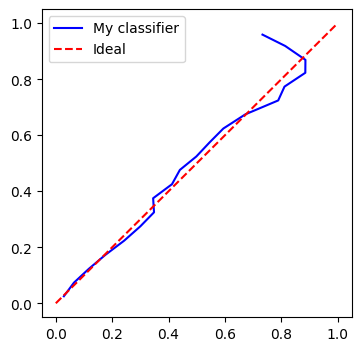

In [109]:
plt.figure(figsize=(4, 4))
prob_true, prob_pred = calibration_curve(y_valid, y_pred_valid, n_bins=20)
plt.plot(prob_true, prob_pred, 'b', label='My classifier')
plt.plot([0, 1], [0, 1], '--r', label='Ideal')
plt.legend(loc=2)
plt.show()

In [35]:
train_data['accept_prob'] = acceptance_model.predict_proba(X)[:, 1]
print(f"Check ROC-AUC = {roc_auc_score(train_data['Accept'], train_data['accept_prob'])}")
test_data['accept_prob'] = acceptance_model.predict_proba(X_test)[:, 1]
print(f"Check ROC-AUC = {roc_auc_score(test_data['Accept'], test_data['accept_prob'])}")
# train_data.to_csv('train_data_new.csv', index=False)
# test_data.to_csv('test_data_new.csv', index=False)

Check ROC-AUC = 0.8491945045537781
Check ROC-AUC = 0.8446798647870659


In [29]:
# !zip archive_new.zip train_data_new.csv test_data_new.csv

  adding: train_data_new.csv (deflated 68%)
  adding: test_data_new.csv (deflated 68%)


### LightGBM на Accept:

In [14]:
def optimize_lgbm(X, y, n_trials=100):
    def objective(trial):
        params = {
            'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
            'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
            'min_split_gain': trial.suggest_discrete_uniform('min_split_gain', 0.1, 5, 0.01),
            'max_depth': trial.suggest_int('max_depth', 1, 9),
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
            'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
            'max_bin': trial.suggest_int('max_bin', 32, 255),
            'random_state': 19,
            'class_weight': 'balanced',
        }

        cv = StratifiedKFold(n_splits=5)
        model = LGBMClassifier(**params)
        scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', verbose=False)
        score = np.mean(scores)

        return score

    sampler = TPESampler(seed=19)
    study = create_study(direction='maximize', study_name="LGBM Classifier", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_pars_mass = study.best_params
    print(f'Best score: {study.best_value}')
    return best_pars_mass

In [10]:
column_transformer_mean_target = ColumnTransformer([
    ('mean_target', TargetEncoder(cols=cat_cols), cat_cols),
    ('pass', 'passthrough', num_cols + other),
])

In [12]:
X_train_enc = column_transformer_mean_target.fit_transform(X_train, y_train)

In [15]:
best_params = optimize_lgbm(X_train_enc, y_train, 50)

[I 2023-04-22 22:56:22,360] A new study created in memory with name: LGBM Classifier


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-04-22 22:56:48,094] Trial 0 finished with value: 0.8325097030483268 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.8325097030483268.
[I 2023-04-22 22:57:43,874] Trial 1 finished with value: 0.889205704461199 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 1 with value: 0.8892

[I 2023-04-22 23:06:24,097] Trial 16 finished with value: 0.8995718825875679 and parameters: {'min_child_samples': 66, 'min_data_in_bin': 71, 'min_split_gain': 3.04, 'max_depth': 8, 'n_estimators': 446, 'learning_rate': 0.06988564094438844, 'boosting_type': 'gbdt', 'reg_alpha': 4.21505976926518, 'reg_lambda': 1.9894511379521682, 'num_leaves': 229, 'colsample_bytree': 0.8486173686066003, 'subsample': 0.47610752212083524, 'subsample_freq': 3, 'max_bin': 244}. Best is trial 4 with value: 0.9004958040059643.
[I 2023-04-22 23:06:58,632] Trial 17 finished with value: 0.9024459548227929 and parameters: {'min_child_samples': 40, 'min_data_in_bin': 12, 'min_split_gain': 1.7500000000000002, 'max_depth': 8, 'n_estimators': 453, 'learning_rate': 0.06303878469141456, 'boosting_type': 'gbdt', 'reg_alpha': 4.618113036614872, 'reg_lambda': 2.1125821569067034, 'num_leaves': 180, 'colsample_bytree': 0.86653045382639, 'subsample': 0.6281227540503689, 'subsample_freq': 3, 'max_bin': 254}. Best is trial 17

[I 2023-04-22 23:18:22,216] Trial 32 finished with value: 0.9001268825819319 and parameters: {'min_child_samples': 34, 'min_data_in_bin': 33, 'min_split_gain': 1.31, 'max_depth': 4, 'n_estimators': 559, 'learning_rate': 0.09196015366297842, 'boosting_type': 'gbdt', 'reg_alpha': 6.241599072772862, 'reg_lambda': 3.00699439767091, 'num_leaves': 95, 'colsample_bytree': 0.6983201331056106, 'subsample': 0.6801811377153665, 'subsample_freq': 2, 'max_bin': 207}. Best is trial 25 with value: 0.9024546865625054.
[I 2023-04-22 23:18:43,977] Trial 33 finished with value: 0.9014915335876978 and parameters: {'min_child_samples': 19, 'min_data_in_bin': 51, 'min_split_gain': 1.86, 'max_depth': 6, 'n_estimators': 527, 'learning_rate': 0.0915839600398036, 'boosting_type': 'gbdt', 'reg_alpha': 4.632122967447247, 'reg_lambda': 1.0745276233820646, 'num_leaves': 169, 'colsample_bytree': 0.6195157009681914, 'subsample': 0.6264189470894124, 'subsample_freq': 2, 'max_bin': 228}. Best is trial 25 with value: 0.

[I 2023-04-22 23:31:28,265] Trial 48 finished with value: 0.9000291518250398 and parameters: {'min_child_samples': 47, 'min_data_in_bin': 202, 'min_split_gain': 2.3600000000000003, 'max_depth': 8, 'n_estimators': 581, 'learning_rate': 0.06091092526304118, 'boosting_type': 'dart', 'reg_alpha': 3.278619583580455, 'reg_lambda': 0.6912731771074665, 'num_leaves': 29, 'colsample_bytree': 0.9983040688161755, 'subsample': 0.6997011702612052, 'subsample_freq': 1, 'max_bin': 245}. Best is trial 45 with value: 0.9036307519568988.
[I 2023-04-22 23:32:09,820] Trial 49 finished with value: 0.9032626395714495 and parameters: {'min_child_samples': 59, 'min_data_in_bin': 224, 'min_split_gain': 2.05, 'max_depth': 9, 'n_estimators': 587, 'learning_rate': 0.0679386366343322, 'boosting_type': 'gbdt', 'reg_alpha': 2.520042922895201, 'reg_lambda': 1.7642838917440364, 'num_leaves': 83, 'colsample_bytree': 0.9536393144726263, 'subsample': 0.7356858903067232, 'subsample_freq': 1, 'max_bin': 228}. Best is trial 

In [17]:
pipeline_lgbm = Pipeline(
    steps=[
        ('preprocessing', column_transformer_mean_target),
        ('model', LGBMClassifier(**best_params))
    ]
)
pipeline_lgbm.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('mean_target',
                                                  TargetEncoder(cols=['Tier',
                                                                      'Partner '
                                                                      'Bin']),
                                                  ['Tier', 'Partner Bin']),
                                                 ('pass', 'passthrough',
                                                  ['FICO', 'Term', 'Amount',
                                                   'Previous_Rate',
                                                   'Competition_rate',
                                                   'Cost_Funds', 'Rate',
                                                   'Car_Type_N', 'Car_Type_R',
                                                   'Car_Type_U'])])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.9634958907484779,
                                learning_rate=0.06707142590628518, max_bin=247,
                                max_depth=9, min_child_samples=47,
                                min_data_in_bin=197, min_split_gain=2.03,
                                n_estimators=573, num_leaves=88,
                                reg_alpha=3.419325855056987,
                                reg_lambda=2.145198023541925,
                                subsample=0.6984360416766194,
                                subsample_freq=1))])

In [110]:
y_pred_train = pipeline_lgbm.predict_proba(X_train)[:, 1]
y_pred_valid = pipeline_lgbm.predict_proba(X_valid)[:, 1]
y_pred_test = pipeline_lgbm.predict_proba(X_test)[:, 1]
print(f'Train ROC-AUC = {roc_auc_score(y_train, y_pred_train)}')
print(f'Valid ROC-AUC = {roc_auc_score(y_valid, y_pred_valid)}')
print(f'Test ROC-AUC = {roc_auc_score(y_test, y_pred_test)}')

Train ROC-AUC = 0.9113388972514602
Valid ROC-AUC = 0.9117439943135851
Test ROC-AUC = 0.9009580500971702


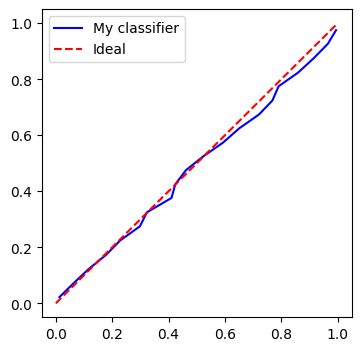

In [111]:
plt.figure(figsize=(4, 4))
prob_true, prob_pred = calibration_curve(y_valid, y_pred_valid, n_bins=20)
plt.plot(prob_true, prob_pred, 'b', label='My classifier')
plt.plot([0, 1], [0, 1], '--r', label='Ideal')
plt.legend(loc=2)
plt.show()

In [19]:
acceptance_model_name = 'acceptance_lgbm_model'
joblib.dump(pipeline_lgbm, f'./{acceptance_model_name}.pkl')
acceptance_model = joblib.load(f'./{acceptance_model_name}.pkl')

### RandomForest на Accept:

In [271]:
def optimize_rf(X, y, n_trials=100):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'n_jobs': -1,
            'random_state': 19,
        }

        cv = StratifiedKFold(n_splits=5)
        model = RandomForestClassifier(**params)
        scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', verbose=False)
        score = np.mean(scores)

        return score

    sampler = TPESampler(seed=19)
    study = create_study(direction='maximize', study_name="RF Classifier", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_pars_mass = study.best_params
    print(f'Best score {study.best_value}')
    return best_pars_mass

In [268]:
column_transformer_mean_target = ColumnTransformer([
    ('mean_target', TargetEncoder(cols=cat_cols), cat_cols),
    ('pass', 'passthrough', num_cols + other),
])

In [269]:
X_train_enc = column_transformer_mean_target.fit_transform(X_train, y_train)

In [272]:
best_params = optimize_rf(X_train_enc, y_train, 50)

[I 2023-04-24 22:16:54,653] A new study created in memory with name: RF Classifier


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-04-24 22:17:09,407] Trial 0 finished with value: 0.7903806230057342 and parameters: {'max_depth': 2, 'n_estimators': 393, 'max_features': None, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7903806230057342.
[I 2023-04-24 22:17:25,062] Trial 1 finished with value: 0.8826890345379367 and parameters: {'max_depth': 12, 'n_estimators': 413, 'max_features': 'sqrt', 'min_samples_leaf': 11}. Best is trial 1 with value: 0.8826890345379367.
[I 2023-04-24 22:17:30,319] Trial 2 finished with value: 0.8727366353404798 and parameters: {'max_depth': 8, 'n_estimators': 155, 'max_features': 'log2', 'min_samples_leaf': 11}. Best is trial 1 with value: 0.8826890345379367.
[I 2023-04-24 22:17:38,597] Trial 3 finished with value: 0.8552002012108956 and parameters: {'max_depth': 5, 'n_estimators': 360, 'max_features': 'log2', 'min_samples_leaf': 13}. Best is trial 1 with value: 0.8826890345379367.
[I 2023-04-24 22:17:50,346] Trial 4 finished with value: 0.879047642922614 and parameters: {'m

[I 2023-04-24 22:30:30,096] Trial 35 finished with value: 0.8840080824440847 and parameters: {'max_depth': 19, 'n_estimators': 434, 'max_features': 'log2', 'min_samples_leaf': 17}. Best is trial 33 with value: 0.8891439183707188.
[I 2023-04-24 22:31:30,927] Trial 36 finished with value: 0.88911591792568 and parameters: {'max_depth': 17, 'n_estimators': 406, 'max_features': None, 'min_samples_leaf': 12}. Best is trial 33 with value: 0.8891439183707188.
[I 2023-04-24 22:31:48,129] Trial 37 finished with value: 0.8811973113549918 and parameters: {'max_depth': 11, 'n_estimators': 408, 'max_features': 'log2', 'min_samples_leaf': 12}. Best is trial 33 with value: 0.8891439183707188.
[I 2023-04-24 22:32:54,082] Trial 38 finished with value: 0.8890273189347513 and parameters: {'max_depth': 17, 'n_estimators': 449, 'max_features': None, 'min_samples_leaf': 15}. Best is trial 33 with value: 0.8891439183707188.
[I 2023-04-24 22:33:44,578] Trial 39 finished with value: 0.8864633390061092 and param

In [276]:
pipeline_rf = Pipeline(
    steps=[
        ('preprocessing', column_transformer_mean_target),
        ('model', RandomForestClassifier(**best_params))
    ]
)
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('mean_target',
                                                  TargetEncoder(cols=['Tier',
                                                                      'Partner '
                                                                      'Bin']),
                                                  ['Tier', 'Partner Bin']),
                                                 ('pass', 'passthrough',
                                                  ['FICO', 'Term', 'Amount',
                                                   'Previous_Rate',
                                                   'Competition_rate',
                                                   'Cost_Funds', 'Rate',
                                                   'Car_Type_N', 'Car_Type_R',
                                                   'Car_Type_U'])])),
                ('model',
                 RandomForestClassifier(max_depth=23, max_features=None,
                                        min_samples_leaf=14, n_estimators=105,
                                        n_jobs=-1, random_state=19))])

In [277]:
y_pred_train = pipeline_rf.predict_proba(X_train)[:, 1]
y_pred_valid = pipeline_rf.predict_proba(X_valid)[:, 1]
y_pred_test = pipeline_rf.predict_proba(X_test)[:, 1]
print(f'Train ROC-AUC = {roc_auc_score(y_train, y_pred_train)}')
print(f'Valid ROC-AUC = {roc_auc_score(y_valid, y_pred_valid)}')
print(f'Test ROC-AUC = {roc_auc_score(y_test, y_pred_test)}')

Train ROC-AUC = 0.9439416298736929
Valid ROC-AUC = 0.8933848566250957
Test ROC-AUC = 0.8887829336239049


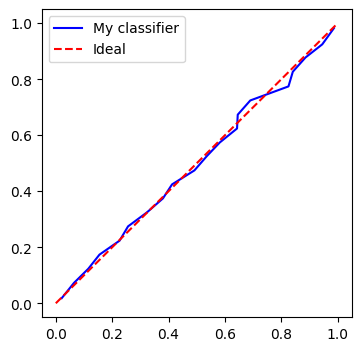

In [279]:
plt.figure(figsize=(4, 4))
prob_true, prob_pred = calibration_curve(y_valid, y_pred_valid, n_bins=20)
plt.plot(prob_true, prob_pred, 'b', label='My classifier')
plt.plot([0, 1], [0, 1], '--r', label='Ideal')
plt.legend(loc=2)
plt.show()

In [280]:
acceptance_model_name = 'acceptance_rf_model'
joblib.dump(pipeline_rf, f'./{acceptance_model_name}.pkl')
acceptance_model = joblib.load(f'./{acceptance_model_name}.pkl')